In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pysam
import os
import ast
import numpy as np
import json
import collections

In [11]:
goodElements=['SINE/Alu','LINE/L1','Retroposon/SVA','snRNA']

In [12]:
replaceDict={'ALU':'SINE/Alu', 'LINE1':'LINE/L1', 'SVA':'Retroposon/SVA', 'LINE':'LINE/L1', 'HERVK':'HERVK'}

In [13]:
# Arthur and Ryan's Callset

In [14]:
arthurDF1 = pd.read_csv("/home/mark/Desktop/MEI_Group/HGSVC3/Arthur/hg38_HGSVC3.MEI.ConsensusMSA.20240503.vcf", sep='\t')
print(len(arthurDF1))
arthurDF1['SV_Length']=[len(x.split("SEQ=")[1].split(";")[0]) for x in arthurDF1['INFO']]
arthurDF1['Element']=[replaceDict[x.split("ME:")[1].split(">")[0]] for x in arthurDF1['ALT']]
arthurDF1['Sequence']= [arthurDF1.at[row,'INFO'].split("SEQ=")[1].split(";")[0] for row in arthurDF1.index]
arthurDF = arthurDF1[arthurDF1['ALT']!='<INS:ME:HERVK>'].copy()
print(len(arthurDF))

13649
13642


In [6]:
arthurDF1[(arthurDF1['CHROM']=='chr18') & (arthurDF1['POS']==28271207)]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00171,...,HG00864,HG03732,NA12329,NA18939,NA19238,NA19239,NA19240,SV_Length,Element,Sequence
5143,chr18,28271207,MEI_5669-chr18-28271207,T,<INS:ME:ALU>,.,PASS,"CALLERS=PALMER2;CIPOS=0,0;SVLEN=354;SUBFAM=Alu...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,1|0,0|0,354,SINE/Alu,TAGGATTGTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTGAGAC...


In [7]:
#for x in arthurDF1[arthurDF1['POS']==145027990]['Sequence']:
#    print(x)

In [8]:
# Mark and Miriam's Callset

In [9]:
t2t_mm = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/MYcallSet/T2T_MEI_INS_06-17-2024_Filtered.csv').set_index("ID")
hg38_mm = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/MYcallSet/hg38_MEI_INS_06-17-2024_Filtered.csv').set_index("ID")

In [10]:
# Jonathan and Scott's Callset

In [11]:
t2t_js= pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Devines/hs1_PAV_freeze4_MELT-RISC-v1.4.2-90-90-SVA-40-90-no-SVA-SVA.vcf', sep='\t').set_index("ID")
t2t_js['Shared_ID']=['-'.join(x.split("-")[:-1]) for x in t2t_js.index]
t2t_js['TE_Designation']=[replaceDict[x.split("-")[-1]] for x in t2t_js.index]
t2t_js.set_index("Shared_ID", inplace=True)


hg38_js= pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Devines/hg38_PAV_freeze4_MELT-RISC-v1.4.2-90-90-SVA-40-90-no-SVA-SVA.vcf', sep='\t').set_index("ID")
hg38_js['Shared_ID']=['-'.join(x.split("-")[:-1]) for x in hg38_js.index]
hg38_js['TE_Designation']=[replaceDict[x.split("-")[-1]] for x in hg38_js.index]
hg38_js.set_index("Shared_ID", inplace=True)

# Start Merging

In [12]:
t2t_Dict={x:{'Callers':['Mark_and_Miriam'], 'Caller_Count':1, 'Element_Type':str(t2t_mm.at[x,'TE_Designation'])} for x in t2t_mm.index}
hg38_Dict={x:{'Callers':['Mark_and_Miriam'], 'Caller_Count':1, 'Element_Type':str(hg38_mm.at[x,'TE_Designation'])} for x in hg38_mm.index}

In [13]:
for row in t2t_js.index:
    if row in t2t_Dict.keys():
        if 'Jonathan_and_Scott' in str(t2t_Dict[row]['Callers']):
            continue
        else:
            t2t_Dict[row]['Callers'].append("Jonathan_and_Scott")
            t2t_Dict[row]['Caller_Count']+=1
    else:
        t2t_Dict[row]={'Callers':['Jonathan_and_Scott'], 'Caller_Count':1, 'Element_Type':str(t2t_js.at[row,'TE_Designation'])}
        
        
for row in hg38_js.index:
    if row in hg38_Dict.keys():
        if 'Jonathan_and_Scott' in str(hg38_Dict[row]['Callers']):
            continue
        else:
            hg38_Dict[row]['Callers'].append("Jonathan_and_Scott")
            hg38_Dict[row]['Caller_Count']+=1
    else:
        hg38_Dict[row]={'Callers':['Jonathan_and_Scott'], 'Caller_Count':1, 'Element_Type':str(hg38_js.at[row,'TE_Designation'])}

In [14]:
def pullInfo(inputDict):
    shared=0
    mm=0
    js=0
    mmList = []
    jsList = []
    
    for key in inputDict.keys():
        
        callerList = inputDict[key]['Callers']
        element = inputDict[key]['Element_Type']
        
        if len(callerList)==2:
            shared+=1
        else:
            
            for call in callerList:
                
                if 'Mark' in str(call):
                    mmList.append(element)
                    mm+=1
                else:
                    jsList.append(element)
                    js+=1
                    
    tempList=[[shared, 'Shared_Calls'],
              [mm, 'Mark_and_Miriam'],
              [js, 'Jonathan_and_Scott']]
    
    t2t_CallerDF = pd.DataFrame(data=tempList, columns=['Count','Callers'])
    t2t_CallerDF
    
    return(t2t_CallerDF, mmList, jsList)

In [15]:
t2t_Element_CountDF, mmT2TElement, jsT2TElement = pullInfo(t2t_Dict)
hg38_Element_CountDF, mmhg38Element, jshg38Element = pullInfo(hg38_Dict)

In [18]:
print(collections.Counter(mmT2TElement))

Counter({'LINE/L1': 449, 'SINE/Alu': 327, 'Retroposon/SVA': 192, 'snRNA': 1})


In [19]:
print(collections.Counter(jsT2TElement))

Counter({'SINE/Alu': 196, 'LINE/L1': 126, 'Retroposon/SVA': 21})


In [20]:
print(collections.Counter(mmhg38Element))

Counter({'LINE/L1': 433, 'SINE/Alu': 301, 'Retroposon/SVA': 178, 'snRNA': 1})


In [21]:
print(collections.Counter(jshg38Element))

Counter({'SINE/Alu': 209, 'LINE/L1': 139, 'Retroposon/SVA': 23})


In [22]:
t2t_Element_CountDF

,Count,Callers
0,12113,Shared_Calls
1,969,Mark_and_Miriam
2,343,Jonathan_and_Scott


In [23]:
hg38_Element_CountDF

,Count,Callers
0,12022,Shared_Calls
1,913,Mark_and_Miriam
2,371,Jonathan_and_Scott


## Time To add In Arthur's Calls

In [24]:
chromList=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY']

In [25]:
t2t_allCaller_Dict={x:{} for x in chromList}
hg38_allCaller_Dict={x:{} for x in chromList}

In [26]:
for key in t2t_Dict.keys():
    if key.split("-")[1] in t2t_allCaller_Dict[key.split("-")[0]]:
        t2t_allCaller_Dict[key.split("-")[0]][key.split("-")[1]][key]={'Element_Type':t2t_Dict[key]['Element_Type']}
    else:
        t2t_allCaller_Dict[key.split("-")[0]][key.split("-")[1]]={key:{'Element_Type':t2t_Dict[key]['Element_Type']}}

In [27]:
for key in hg38_Dict.keys():
    if key.split("-")[0] in hg38_allCaller_Dict.keys():
        if key.split("-")[1] in hg38_allCaller_Dict[key.split("-")[0]]:
            hg38_allCaller_Dict[key.split("-")[0]][key.split("-")[1]][key]={'Element_Type':hg38_Dict[key]['Element_Type']}
        else:
            hg38_allCaller_Dict[key.split("-")[0]][key.split("-")[1]]={key:{'Element_Type':hg38_Dict[key]['Element_Type']}}
    else:
        hg38_allCaller_Dict[key.split("-")[0]]={}
        if key.split("-")[1] in hg38_allCaller_Dict[key.split("-")[0]]:
            hg38_allCaller_Dict[key.split("-")[0]][key.split("-")[1]][key]={'Element_Type':hg38_Dict[key]['Element_Type']}
        else:
            hg38_allCaller_Dict[key.split("-")[0]][key.split("-")[1]]={key:{'Element_Type':hg38_Dict[key]['Element_Type']}}

In [28]:
## Read in Arthurs

In [29]:
arthur_Dict={x:{} for x in set(arthurDF['CHROM'])}
for row in arthurDF.index:
    pos = int(arthurDF.at[row,'POS'])
    if pos in arthur_Dict[str(arthurDF.at[row,'CHROM'])]:
        #print(row)
        #print(str(arthurDF.at[row,'CHROM']))
        #print(pos)
        arthur_Dict[str(arthurDF.at[row,'CHROM'])][pos][row]={'Element':str(arthurDF.at[row,'Element']), 'Comparisons':{}}
        
    else:
        arthur_Dict[str(arthurDF.at[row,'CHROM'])][pos]={row:{'Element':str(arthurDF.at[row,'Element']), 'Comparisons':{}}}

In [30]:
arthur_Dict

{'chr17': {227349: {4657: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  758932: {4658: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  831917: {4659: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1212118: {4660: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1419283: {4661: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1472792: {4662: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1567297: {4663: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1696154: {4664: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1704863: {4665: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  2408435: {4666: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  2548298: {4667: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  2562917: {4668: {'Element': 'Retroposon/SVA', 'Comparisons': {}}},
  2739195: {4669: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  2760507: {4670: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  3076177: {4671: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  3284831: {4672: {'Element': 'SINE/Alu', '

In [31]:
for chromosome in arthur_Dict.keys():
    for position in arthur_Dict[chromosome]:
        for row in arthur_Dict[chromosome][position]:
            
            ########################################################
            for position2 in hg38_allCaller_Dict[chromosome]:

                if abs(int(position)-int(position2))<1000:
                    #print('yes')
                    for pavid in hg38_allCaller_Dict[chromosome][position2]:

                        if str(hg38_allCaller_Dict[chromosome][position2][pavid]['Element_Type']) == str(arthur_Dict[chromosome][position][row]['Element']):
                            #print('yes', chromosome, position)
                            arthur_Dict[chromosome][position][row]['Comparisons'][pavid]='Not_Tested'
                        else:
                            continue
                else:
                    continue

In [32]:
arthur_Dict[chromosome]

{182788: {4324: {'Element': 'SINE/Alu', 'Comparisons': {}}},
 357289: {4325: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-357290-INS-343': 'Not_Tested'}}},
 417162: {4326: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-417163-INS-311': 'Not_Tested'}}},
 419716: {4327: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-419717-INS-342': 'Not_Tested'}}},
 692489: {4328: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-692490-INS-358': 'Not_Tested'}}},
 738519: {4329: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-738520-INS-332': 'Not_Tested'}}},
 821899: {4330: {'Element': 'LINE/L1',
   'Comparisons': {'chr16-821900-INS-6056': 'Not_Tested'}}},
 1484887: {4331: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-1484888-INS-318': 'Not_Tested'}}},
 1685737: {4332: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-1685738-INS-328': 'Not_Tested'}}},
 2052215: {4333: {'Element': 'SINE/Alu',
   'Comparisons': {'chr16-2052216-INS-333': 'Not_Tested'}}},
 2362366: {4334: {'Element': 'SIN

In [33]:
from Bio.Seq import Seq 
from Bio import pairwise2
from scipy.spatial import distance
from tqdm import tqdm

for chromosome in arthur_Dict.keys():
    print(chromosome)
    for position in tqdm(arthur_Dict[chromosome]):
        for row in arthur_Dict[chromosome][position]:
            for pavID in arthur_Dict[chromosome][position][row]['Comparisons']:
                
                sequence1 = Seq(arthurDF.at[row,'Sequence'])
                if pavID in hg38_mm.index:
                    sequence2 = Seq(hg38_mm.at[pavID,'ALT'])
                else:
                    sequence2 = Seq(hg38_js.at[pavID,'ALT'])
                        
                alignments = pairwise2.align.globalxs(sequence1, sequence2, -1, -1)
                distances=[]
                for alignment in alignments: 
                    seq1=[x for x in alignment.seqA]
                    seq2 =[y for y in alignment.seqB]
                    distances.append(distance.hamming(seq1, seq2))

                bestMatch = min(distances)
                arthur_Dict[chromosome][position][row]['Comparisons'][pavID]=bestMatch

/home/mark/anaconda3/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


chr17


100%|█████████████████████████████████████████| 369/369 [00:47<00:00,  7.81it/s]


chr4


100%|█████████████████████████████████████████| 895/895 [02:37<00:00,  5.69it/s]


chr18


100%|█████████████████████████████████████████| 365/365 [00:34<00:00, 10.46it/s]


chr8


100%|█████████████████████████████████████████| 664/664 [01:22<00:00,  8.06it/s]


chr6


100%|█████████████████████████████████████████| 950/950 [02:16<00:00,  6.98it/s]


chr3


100%|█████████████████████████████████████████| 923/923 [02:51<00:00,  5.38it/s]


chr2


100%|███████████████████████████████████████| 1035/1035 [03:01<00:00,  5.71it/s]


chr21


100%|█████████████████████████████████████████| 240/240 [00:12<00:00, 18.95it/s]


chrY


100%|███████████████████████████████████████████| 25/25 [00:05<00:00,  4.88it/s]


chr20


100%|█████████████████████████████████████████| 307/307 [00:42<00:00,  7.15it/s]


chr12


100%|█████████████████████████████████████████| 641/641 [01:43<00:00,  6.21it/s]


chr11


100%|█████████████████████████████████████████| 600/600 [01:41<00:00,  5.89it/s]


chr1


100%|███████████████████████████████████████| 1126/1126 [02:37<00:00,  7.13it/s]


chr14


100%|█████████████████████████████████████████| 428/428 [01:14<00:00,  5.75it/s]


chr19


100%|█████████████████████████████████████████| 291/291 [00:23<00:00, 12.65it/s]


chr7


100%|█████████████████████████████████████████| 793/793 [02:01<00:00,  6.51it/s]


chr5


100%|█████████████████████████████████████████| 929/929 [02:14<00:00,  6.92it/s]


chr15


100%|█████████████████████████████████████████| 413/413 [01:08<00:00,  6.03it/s]


chr9


100%|█████████████████████████████████████████| 630/630 [01:26<00:00,  7.25it/s]


chrX


100%|█████████████████████████████████████████| 349/349 [01:17<00:00,  4.50it/s]


chr13


100%|█████████████████████████████████████████| 508/508 [01:15<00:00,  6.72it/s]


chr22


100%|█████████████████████████████████████████| 220/220 [00:26<00:00,  8.21it/s]


chr10


100%|█████████████████████████████████████████| 606/606 [01:42<00:00,  5.93it/s]


chr16


100%|█████████████████████████████████████████| 333/333 [00:35<00:00,  9.45it/s]


In [35]:
import json
#with open('/home/mark/Desktop/MEI_Group/HGSVC3/json/arthur_hg38_Similarities.json', 'w') as fp:
#    json.dump(arthur_Dict, fp)
import json
#with open('/home/mark/Desktop/MEI_Group/HGSVC3/json/arthur_hg38_Similarities.json') as json_file:
  #  arthur_Dict = json.load(json_file)

In [36]:
arthur_Dict

{'chr17': {227349: {4657: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-227350-INS-324': 0.003076923076923077}}},
  758932: {4658: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-758933-INS-336': 0.002967359050445104}}},
  831917: {4659: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-831918-INS-312': 0.006369426751592357}}},
  1212118: {4660: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-1212119-INS-335': 0.005934718100890208}}},
  1419283: {4661: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1472792: {4662: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-1472793-INS-325': 0.0061162079510703364}}},
  1567297: {4663: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  1696154: {4664: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-1696155-INS-309': 0.0032258064516129032}}},
  1704863: {4665: {'Element': 'SINE/Alu',
    'Comparisons': {'chr17-1704864-INS-316': 0.006309148264984227}}},
  2408435: {4666: {'Element': 'SINE/Alu', 'Comparisons': {}}},
  2548298: {4667: {'El

In [37]:
hg38_Dict2 = hg38_Dict.copy()
hg38_Dict2

{'chr1-59599-INS-315': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_Count': 2,
  'Element_Type': 'SINE/Alu'},
 'chr1-362687-INS-315': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_Count': 2,
  'Element_Type': 'SINE/Alu'},
 'chr1-683234-INS-2747': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_Count': 2,
  'Element_Type': 'Retroposon/SVA'},
 'chr1-710580-INS-315': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_Count': 2,
  'Element_Type': 'SINE/Alu'},
 'chr1-868471-INS-2554': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_Count': 2,
  'Element_Type': 'Retroposon/SVA'},
 'chr1-1885906-INS-328': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_Count': 2,
  'Element_Type': 'SINE/Alu'},
 'chr1-3095324-INS-336': {'Callers': ['Mark_and_Miriam'],
  'Caller_Count': 1,
  'Element_Type': 'SINE/Alu'},
 'chr1-3787549-INS-322': {'Callers': ['Mark_and_Miriam', 'Jonathan_and_Scott'],
  'Caller_

In [38]:
import ast

for chromosome in arthur_Dict.keys():
    for position in arthur_Dict[chromosome]:
        for row in arthur_Dict[chromosome][position]:
            
            if len(arthur_Dict[chromosome][position][row]['Comparisons']) == 0:
                hg38_Dict2[arthurDF.at[row,'ID']]={'Callers':['Arthur_and_Ryan'], 'Caller_Count':1, 'Element_Type':arthur_Dict[chromosome][position][row]['Element']}
                
            else:
                
                tempDict = arthur_Dict[chromosome][position][row]['Comparisons']
                bestMatch = min(tempDict, key=tempDict.get)
                
                if float(tempDict[bestMatch])<=.1:
                    if 'Arthur_and_Ryan' in hg38_Dict2[bestMatch]['Callers']:
                        continue
                    else:
                        hg38_Dict2[bestMatch]['Callers'].append('Arthur_and_Ryan')
                        hg38_Dict2[bestMatch]['Caller_Count']+=1
                        hg38_Dict2[bestMatch]['Arthur_ID']=arthurDF.at[row,'ID']
                else:
                    hg38_Dict2[arthurDF.at[row,'ID']]={'Callers':['Arthur_and_Ryan'], 'Caller_Count':1, 'Element_Type':arthur_Dict[chromosome][position][row]['Element']}

In [39]:
for call in hg38_Dict2.keys():
    if hg38_Dict2[call]['Caller_Count']==1:
        print(call)

chr1-24253075-INS-3366
chr1-27991774-INS-3788
chr1-52342849-INS-6700
chr1-62931961-INS-2715
chr1-81478072-INS-4358
chr1-101513425-INS-2986
chr1-105373672-INS-2374
chr1-105965567-INS-3369
chr1-158756068-INS-944
chr1-166720669-INS-67
chr1-168956832-INS-2626
chr1-175103566-INS-3655
chr1-179522824-INS-353
chr1-184981335-INS-335
chr1-189747953-INS-590
chr1-194440438-INS-865
chr1-194965512-INS-1461
chr1-194967501-INS-2623
chr1-206436512-INS-1723
chr1-214887042-INS-1671
chr1-221654462-INS-627
chr1-227574493-INS-2691
chr1-242320190-INS-6796
chr10-3041562-INS-3270
chr10-49953236-INS-4037
chr10-60569089-INS-2560
chr10-107191515-INS-2137
chr10-124751431-INS-2303
chr10-128388780-INS-911
chr11-6712599-INS-4443
chr11-29463654-INS-3161
chr11-50356524-INS-955
chr11-55605404-INS-2910
chr11-59913089-INS-2869
chr11-73816359-INS-3962
chr11-80709087-INS-204
chr11-98686737-INS-3419
chr11-100560575-INS-1287
chr11-107903462-INS-1981
chr11-108678769-INS-146
chr11-123118932-INS-410
chr11-130012650-INS-3238
chr1

In [40]:
hervkRows = [x for x in arthurDF1[arthurDF1['ALT']=='<INS:ME:HERVK>'].index]

In [41]:
markList=[]
jonathanList=[]
arthurList=[]
for call in hg38_Dict2.keys():
    if 'Mark_and_Miriam' in hg38_Dict2[call]['Callers']:
        markList.append(call)
    elif 'Jonathan_and_Scott' in hg38_Dict2[call]['Callers']:
        jonathanList.append(call)
    else:
        arthurList.append(call)

In [42]:
arthurDF.set_index("ID", inplace=True)

In [43]:
dataframes = [hg38_mm, hg38_js.loc[jonathanList], arthurDF.loc[arthurList], arthurDF1.loc[hervkRows].set_index("ID")]
combinedDF = pd.concat(dataframes)

In [44]:
combinedDF['Callers'] = [hg38_Dict2[x]['Callers'] if x in hg38_Dict2.keys() else ['Arthur_and_Ryan'] for x in combinedDF.index ]
combinedDF['Caller_Count'] = [hg38_Dict2[x]['Caller_Count'] if x in hg38_Dict2.keys() else 1 for x in combinedDF.index]

In [45]:
combinedDF

,CHROM,POS,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,HG00171,...,Orientation,FILTER_RESULTS,Tail_Length,Tail_Seed_Hits,Unique_Element_Count,Twin_Priming_Flag,Element,Sequence,Callers,Caller_Count
chr1-59599-INS-315,chr1,59598,T,TAGGATTCTTTCTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTC...,.,.,ID=chr1-59599-INS-315;VARTYPE=SV;SVTYPE=INS;SV...,GT,.|.|.,.|.|.,...,-,Good_Row,23.0,22.0,One_Element,NONE,NaN,NaN,"[Mark_and_Miriam, Jonathan_and_Scott, Arthur_a...",3
chr1-362687-INS-315,chr1,362686,T,TAGAAGGAATAAGACGGGCCGGGCGCGGTGGCTCACGCCTGTAATC...,.,.,ID=chr1-362687-INS-315;VARTYPE=SV;SVTYPE=INS;S...,GT,.|.|.,.|.|.,...,+,Good_Row,19.0,18.0,One_Element,NONE,NaN,NaN,"[Mark_and_Miriam, Jonathan_and_Scott, Arthur_a...",3
chr1-683234-INS-2747,chr1,683233,G,GAAGAATAGACATTTGTTTCGAGGCTCTTAGTATTCAGTGAAACCT...,.,.,ID=chr1-683234-INS-2747;VARTYPE=SV;SVTYPE=INS;...,GT,.|0|.,0|.|.,...,+,Good_Row,8.0,18.0,One_Element_ODD,NONE,NaN,NaN,"[Mark_and_Miriam, Jonathan_and_Scott, Arthur_a...",3
chr1-710580-INS-315,chr1,710579,T,TAAAGAACTGCCCGGCCGGGCGCGGTGGCTCACGCCTGTAATCCCA...,.,.,ID=chr1-710580-INS-315;VARTYPE=SV;SVTYPE=INS;S...,GT,1|1|.,1|1|.,...,+,Good_Row,22.0,21.0,One_Element,NONE,NaN,NaN,"[Mark_and_Miriam, Jonathan_and_Scott, Arthur_a...",3
chr1-868471-INS-2554,chr1,868470,A,AGGATTTCACAGATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,.,.,ID=chr1-868471-INS-2554;VARTYPE=SV;SVTYPE=INS;...,GT,0|0|.,0|0|.,...,-,Good_Row,44.0,40.0,One_Element,NONE,NaN,NaN,"[Mark_and_Miriam, Jonathan_and_Scott, Arthur_a...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEI_6041-chr19-21658733,chr19,21658733,T,<INS:ME:HERVK>,.,PASS,"CALLERS=PALMER2;CIPOS=0,0;SVLEN=9478;SUBFAM=HE...",GT,0|0,0|0,...,NaN,NaN,NaN,NaN,NaN,NaN,HERVK,ATAGAGTGTAGGGGTGGGTTGCCCCTACACACCTGTGGGTGTTTCT...,[Arthur_and_Ryan],1
MEI_12384-chr7-4583219,chr7,4583219,T,<INS:ME:HERVK>,.,PASS,"CALLERS=PALMER2;CIPOS=0,0;SVLEN=8504;SUBFAM=HE...",GT,0|0,0|0,...,NaN,NaN,NaN,NaN,NaN,NaN,HERVK,CTGAGTGGACACAGCACATGTTTCAGAGAGCACGGGGTTGGGGGTA...,[Arthur_and_Ryan],1
MEI_13330-chr8-7813692,chr8,7813692,T,<INS:ME:HERVK>,.,PASS,"CALLERS=PALMER2;CIPOS=0,0;SVLEN=9468;SUBFAM=HE...",GT,0|0,0|0,...,NaN,NaN,NaN,NaN,NaN,NaN,HERVK,ACCTTTTGTGGGGAAAAGCAAGAGAGATCAGATTGTTACTGTGTCT...,[Arthur_and_Ryan],1
MEI_14010-chr8-145027990,chr8,145027990,T,<INS:ME:HERVK>,.,PASS,"CALLERS=PALMER2;CIPOS=0,0;SVLEN=2880;SUBFAM=SV...",GT,0|0,0|0,...,NaN,NaN,NaN,NaN,NaN,NaN,HERVK,CCCTCAGTTTTTTTTTTTTTTTTTTTTTTTTTTTTAATTTTTTTTT...,[Arthur_and_Ryan],1


In [48]:
ancestralhg38DF = pd.read_csv("/home/mark/Desktop/FunctionalGroup/Ancestral_SV_Check/dataframe/hg38_Annotated_05-01_2024.csv").set_index("ID")

In [49]:
ancestralhg38DF.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'HG00096', 'HG00171', 'HG00268', 'HG00358', 'HG00512', 'HG00513',
       'HG00514', 'HG00731', 'HG00732', 'HG00733', 'HG00864', 'HG01114',
       'HG01352', 'HG01457', 'HG01505', 'HG01573', 'HG01596', 'HG01890',
       'HG02011', 'HG02018', 'HG02059', 'HG02106', 'HG02282', 'HG02492',
       'HG02554', 'HG02587', 'HG02666', 'HG02769', 'HG02818', 'HG02953',
       'HG03009', 'HG03065', 'HG03248', 'HG03371', 'HG03452', 'HG03456',
       'HG03520', 'HG03683', 'HG03732', 'HG03807', 'HG04036', 'HG04217',
       'NA12329', 'NA18534', 'NA18939', 'NA18989', 'NA19036', 'NA19129',
       'NA19238', 'NA19239', 'NA19240', 'NA19317', 'NA19331', 'NA19347',
       'NA19384', 'NA19434', 'NA19650', 'NA19705', 'NA19836', 'NA19983',
       'NA20355', 'NA20509', 'NA20847', 'NA21487', 'NA24385', 'SV_Length',
       'INS_Chimp_Sample_Matches', 'DEL_Chimp_Sample_Matches',
       'Chimp_Sample_Match_Similarity', 'Chimp_Best_Sample_

In [50]:
for row in combinedDF.index:
    if 'MEI' in str(row):
        combinedDF.at[row,'ALT']=combinedDF.at[row,'Sequence']
        combinedDF.at[row,'TE_Designation']=combinedDF.at[row,'Element']
        
    else:
        #combinedDF.at[row,'TE_Percentage']=ancestralhg38DF.at[row,'TE_Percentage']
        #combinedDF.at[row,'TE_Hits']=ancestralhg38DF.at[row,'TE_Hits']
        #combinedDF.at[row,'TE_Designation']=ancestralhg38DF.at[row,'TE_Designation']
        #combinedDF.at[row,'TE_Proportion']=ancestralhg38DF.at[row,'TE_Proportion']
        #combinedDF.at[row,'Tail_Begins']=ancestralhg38DF.at[row,'Tail_Begins']
        #combinedDF.at[row,'Tail_Type']=ancestralhg38DF.at[row,'Tail_Type']
        #combinedDF.at[row,'Element_Annotation']=ancestralhg38DF.at[row,'Element_Annotation']
        #combinedDF.at[row,'Element_Divergence']=ancestralhg38DF.at[row,'Element_Divergence']
        
        combinedDF.at[row,'INS_Chimp_Sample_Matches']=ancestralhg38DF.at[row,'INS_Chimp_Sample_Matches']
        combinedDF.at[row,'DEL_Chimp_Sample_Matches']=ancestralhg38DF.at[row,'DEL_Chimp_Sample_Matches']
        combinedDF.at[row,'Chimp_Sample_Match_Similarity']=ancestralhg38DF.at[row,'Chimp_Sample_Match_Similarity']
        combinedDF.at[row,'Chimp_Best_Sample_Match']=ancestralhg38DF.at[row,'Chimp_Best_Sample_Match']

        combinedDF.at[row,'INS_GorGor_Sample_Matches']=ancestralhg38DF.at[row,'INS_GorGor_Sample_Matches']
        combinedDF.at[row,'DEL_GorGor_Sample_Matches']=ancestralhg38DF.at[row,'DEL_GorGor_Sample_Matches']
        combinedDF.at[row,'GorGor_Sample_Match_Similarity']=ancestralhg38DF.at[row,'GorGor_Sample_Match_Similarity']
        combinedDF.at[row,'GorGor_Best_Sample_Match']=ancestralhg38DF.at[row,'GorGor_Best_Sample_Match']
        combinedDF.at[row,'Ancestral_Findings']=ancestralhg38DF.at[row,'Ancestral_Findings']

        
combinedDF.drop(columns=['Sequence','Element'], inplace=True)

In [51]:
#combinedDF.to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38_MergedCallSet_06-17-2024.csv')

In [52]:
outside=[]
ourSpecific=[]
for row in combinedDF.index:
    callList = ast.literal_eval(str(combinedDF.at[row,'Callers']))
    if len(callList)<=2:
        if 'Mark_and_Miriam' in callList and len(callList)==1:
            ourSpecific.append(row)

        elif 'Jonathan_and_Scott' in callList or 'Arthur_and_Ryan' in callList:
            outside.append(row)
        
        else:
            continue
            
    else:
        continue

## MAKE DATAFRAME FOR VCFDC

In [56]:
knownSpaceList = []
coluumns = ['CHROM', 'POS', 'ID', 'ALT', 'INFO','Original_ID']
i=1
for row in combinedDF.index:
    chrom = str(combinedDF.at[row,'CHROM'])
    poss = str(combinedDF.at[row,'POS'])
    ID = 'MEI_'+str(i)+"-"+str(chrom)+"-"+str(poss)
    length = len(str(combinedDF.at[row,'ALT']))
    element = 'TEMP'
    
    forwardStrand = ['Possible_A-Tail', 'Possible_A-Tail*_and_Possible_T-Tail', 'Possible_A-Tail*_and_Possible_T-Tail*']
    antisenseStrand = ['Possible_A-Tail*_and_Possible_T-Tail*', 'Possible_A-Tail_and_Possible_T-Tail*', 'Possible_T-Tail']
    
    if str(combinedDF.at[row,'Tail_Type']) in forwardStrand:
        goodElementOrientation = '+'
    elif str(combinedDF.at[row,'Tail_Type']) in antisenseStrand:
        goodElementOrientation = '-'
    elif 'MEI' in str(row):
        stranDict={'-':'-', '+':'+'}
        try:
            goodElementOrientation = stranDict[combinedDF.at[row,'INFO'].split("STRAND=")[1].split(";")[0]]
        except:
            goodElementOrientation = '+'
    
    else:
         goodElementOrientation = '+'
    
    
    flag=0
    if 'ALU' in combinedDF.at[row,'TE_Designation'].upper():
        ALT = '<INS:MEI:ALU>'
    elif 'SVA' in combinedDF.at[row,'TE_Designation'].upper():
        ALT = '<INS:MEI:SVA>'
    elif 'LINE' in combinedDF.at[row,'TE_Designation'].upper():
        ALT = '<INS:MEI:LINE>'
    
    else:
        flag+=1
    
    if flag==0:

        INFO = 'SVLEN='+str(length)+";SUBFAM="+str(element)+";STRAND="+str(goodElementOrientation)+";SEQ="+str(str(combinedDF.at[row,'ALT']))
        #print(INFO)
        knownSpaceList.append([chrom,poss,ID,ALT,INFO, row])
        i+=1 
    else:
        continue

knownSpaceDF = pd.DataFrame(data=knownSpaceList, columns=coluumns)
knownSpaceDF.set_index("CHROM").to_csv("/home/mark/Desktop/MEI_Group/HGSVC3/MYcallSet/VCFDC_Merged_hg38_06-17-2024.tsv", sep='\t')

In [57]:
knownSpaceDF

,CHROM,POS,ID,ALT,INFO,Original_ID
0,chr1,59598,MEI_1-chr1-59598,<INS:MEI:ALU>,SVLEN=316;SUBFAM=TEMP;STRAND=-;SEQ=TAGGATTCTTT...,chr1-59599-INS-315
1,chr1,362686,MEI_2-chr1-362686,<INS:MEI:ALU>,SVLEN=316;SUBFAM=TEMP;STRAND=+;SEQ=TAGAAGGAATA...,chr1-362687-INS-315
2,chr1,683233,MEI_3-chr1-683233,<INS:MEI:SVA>,SVLEN=2748;SUBFAM=TEMP;STRAND=+;SEQ=GAAGAATAGA...,chr1-683234-INS-2747
3,chr1,710579,MEI_4-chr1-710579,<INS:MEI:ALU>,SVLEN=316;SUBFAM=TEMP;STRAND=+;SEQ=TAAAGAACTGC...,chr1-710580-INS-315
4,chr1,868470,MEI_5-chr1-868470,<INS:MEI:SVA>,SVLEN=2555;SUBFAM=TEMP;STRAND=-;SEQ=AGGATTTCAC...,chr1-868471-INS-2554
...,...,...,...,...,...,...
14706,chr16,87487308,MEI_14707-chr16-87487308,<INS:MEI:ALU>,SVLEN=317;SUBFAM=TEMP;STRAND=+;SEQ=AAAAAAATCAG...,MEI_5085-chr16-87487308
14707,chr16,89801032,MEI_14708-chr16-89801032,<INS:MEI:ALU>,SVLEN=313;SUBFAM=TEMP;STRAND=+;SEQ=AAAAAAAAAAA...,MEI_5094-chr16-89801032
14708,chr16,89901414,MEI_14709-chr16-89901414,<INS:MEI:ALU>,SVLEN=472;SUBFAM=TEMP;STRAND=+;SEQ=GAGGGGCTGTG...,MEI_5097-chr16-89901414
14709,chr16,90112146,MEI_14710-chr16-90112146,<INS:MEI:ALU>,SVLEN=340;SUBFAM=TEMP;STRAND=+;SEQ=AAGATATATAT...,MEI_5100-chr16-90112146


## Filter the Calls/Visualize

In [13]:
combinedDF=pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38_MergedCallSet_06-17-2024.csv', low_memory=False).set_index("Unnamed: 0")

In [18]:
hg38VCFDC= pd.read_csv("/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/VCFDC/hg38/hg38_06-18-2024_VCFDC_FinalResults.vcf",sep='\t').set_index("Original_ID")

In [19]:
collections.Counter(hg38VCFDC['VCFDC_Designation'])

Counter({'PASSED:High_Confidence': 12662,
         'PASSED:Low_Confidence-Coordinates': 1090,
         'PASSED:Low_Confidence-Alu_Divergence': 461,
         'NOT_PASSED:Assembly/Other_Error': 305,
         'NOT_PASSED:Human_Ref_Deletion': 116,
         'NOT_PASSED:Simply_Bad_Call': 77})

In [20]:
combinedDF['VCFDC']=[hg38VCFDC.at[x,'VCFDC_Designation'] if x in hg38VCFDC.index else 'NONE' for x in combinedDF.index]

In [22]:
passRows=[]
cleanPassedRows=[]
notPassedRows=[]
for row in combinedDF.index:
    if 'NOT_PASSED' in str(combinedDF.at[row,'VCFDC']):
        notPassedRows.append(row)
    else:
        passRows.append(row)
        if '_Match' in str(combinedDF.at[row,'Ancestral_Findings']):
            continue
        else:
            cleanPassedRows.append(row)

In [23]:
collections.Counter(combinedDF.loc[passRows]['Caller_Count'])

Counter({3: 11218, 1: 1589, 2: 1414})

In [140]:
collections.Counter(combinedDF.loc[passRows]['VCFDC'])

Counter({'PASSED:High_Confidence': 12662,
         'PASSED:Low_Confidence-Coordinates': 1090,
         'PASSED:Low_Confidence-Alu_Divergence': 461,
         'NONE': 8})

In [141]:
collections.Counter(combinedDF.loc[passRows]['Ancestral_Findings'])

Counter({'No_Hits': 13035,
         nan: 1175,
         'Chimpanzee_Match': 7,
         'Gorilla_Match': 2,
         'Chimpanzee_and_Gorilla_Match': 2})

In [26]:
passDF = combinedDF.loc[passRows].copy()
collections.Counter(combinedDF.loc[passRows]['Ancestral_Findings'])

Counter({'No_Hits': 13032,
         nan: 1178,
         'Chimpanzee_Match': 7,
         'Gorilla_Match': 2,
         'Chimpanzee_and_Gorilla_Match': 2})

In [27]:
collections.Counter(combinedDF.loc[notPassedRows]['Caller_Count'])

Counter({1: 278, 3: 178, 2: 42})

In [28]:
collections.Counter(combinedDF.loc[notPassedRows]['VCFDC'])

Counter({'NOT_PASSED:Assembly/Other_Error': 305,
         'NOT_PASSED:Human_Ref_Deletion': 116,
         'NOT_PASSED:Simply_Bad_Call': 77})

In [29]:
collections.Counter(combinedDF.loc[notPassedRows]['Ancestral_Findings'])

Counter({'No_Hits': 252,
         nan: 235,
         'Chimpanzee_Match': 7,
         'Chimpanzee_and_Gorilla_Match': 4})

## Plot

In [30]:
combinedDF = combinedDF.loc[cleanPassedRows].copy()

In [124]:
konkelCalls = combinedDF[(combinedDF['Caller_Count']==1) & (combinedDF['Konkel_Lab']==1)].copy()

In [ ]:
chr7-6457170-INS-346 <- interesting

In [131]:
set(konkelCalls['Tail_Type'])

{'No_Tail_Type',
 'Possible_A-Tail',
 'Possible_A-Tail*_and_Possible_T-Tail',
 'Possible_A-Tail_and_Possible_T-Tail*',
 'Possible_T-Tail'}

In [133]:
from Bio.Seq import Seq

atails=['Possible_A-Tail','Possible_A-Tail*_and_Possible_T-Tail']
for row in konkelCalls.index:
    if 'SVA' in str(konkelCalls.at[row,'TE_Designation']).upper():
        element = 'SVA'
    elif 'LINE' in str(konkelCalls.at[row,'TE_Designation']).upper():
        element = 'LINE'
    
    elif 'ALU' in str(konkelCalls.at[row,'TE_Designation']).upper():
        element = 'Alu'
    
    else:
        element=str(konkelCalls.at[row,'TE_Designation'])
        
    with open('/home/mark/Desktop/'+str(element)+"_hg38calls.fasta", 'a+') as file:
        if str(konkelCalls.at[row,'Tail_Type']) in atails:
            file.write(">"+str(row)+"\n")
            sequence = Seq(str(konkelCalls.at[row,'ALT'])).reverse_complement()
            file.write(str(sequence)+"\n")
        else:
            file.write(">"+str(row)+"\n")
            file.write(str(konkelCalls.at[row,'ALT'])+"\n")
    file.close()

In [117]:
print(collections.Counter(combinedDF[combinedDF['Caller_Count']>=2]['TE_Designation']))
print(len(combinedDF[combinedDF['Caller_Count']>=2]))
print('\n')
print(collections.Counter(combinedDF[combinedDF['Caller_Count']==3]['TE_Designation']))
print(len(combinedDF[combinedDF['Caller_Count']==3]))
print('\n')
print(collections.Counter(combinedDF[combinedDF['Caller_Count']==2]['TE_Designation']))
print(len(combinedDF[combinedDF['Caller_Count']==2]))
print('\n')
print(collections.Counter(combinedDF[combinedDF['Caller_Count']==1]['TE_Designation']))
print(len(combinedDF[combinedDF['Caller_Count']==1]))
print('\n')
print(collections.Counter(combinedDF[combinedDF['Caller_Count']>=1]['TE_Designation']))
print(len(combinedDF[combinedDF['Caller_Count']>=1]))
print('\n')

Counter({'SINE/Alu': 10324, 'LINE/L1': 1569, 'Retroposon/SVA': 737})
12630


Counter({'SINE/Alu': 9657, 'LINE/L1': 1068, 'Retroposon/SVA': 492})
11217


Counter({'SINE/Alu': 667, 'LINE/L1': 501, 'Retroposon/SVA': 245})
1413


Counter({'SINE/Alu': 1032, 'LINE/L1': 437, 'Retroposon/SVA': 103, 'HERVK': 7, 'snRNA': 1})
1580


Counter({'SINE/Alu': 11356, 'LINE/L1': 2006, 'Retroposon/SVA': 840, 'HERVK': 7, 'snRNA': 1})
14210




In [32]:
combinedDF['Konkel_Lab']=[1 if 'Mark' in str(combinedDF.at[x,'Callers']) else 0 for x in combinedDF.index ]
combinedDF['Devine_Lab']=[1 if 'Scott' in str(combinedDF.at[x,'Callers']) else 0 for x in combinedDF.index ]
combinedDF['PALMER']=[1 if 'Arthur' in str(combinedDF.at[x,'Callers']) else 0 for x in combinedDF.index ]

In [33]:
for row in combinedDF.index:
    if combinedDF.at[row,'Konkel_Lab']==0 and combinedDF.at[row,'Devine_Lab']==1:
        combinedDF.at[row,'TE_Designation']=hg38_js.at[row,'TE_Designation']
    else:
        continue

In [90]:
pullColumns=['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'HG00096', 'HG00171', 'HG00268', 'HG00358', 'HG00512', 'HG00513',
       'HG00514', 'HG00731', 'HG00732', 'HG00733', 'HG00864', 'HG01114',
       'HG01352', 'HG01457', 'HG01505', 'HG01573', 'HG01596', 'HG01890',
       'HG02011', 'HG02018', 'HG02059', 'HG02106', 'HG02282', 'HG02492',
       'HG02554', 'HG02587', 'HG02666', 'HG02769', 'HG02818', 'HG02953',
       'HG03009', 'HG03065', 'HG03248', 'HG03371', 'HG03452', 'HG03456',
       'HG03520', 'HG03683', 'HG03732', 'HG03807', 'HG04036', 'HG04217',
       'NA12329', 'NA18534', 'NA18939', 'NA18989', 'NA19036', 'NA19129',
       'NA19238', 'NA19239', 'NA19240', 'NA19317', 'NA19331', 'NA19347',
       'NA19384', 'NA19434', 'NA19650', 'NA19705', 'NA19836', 'NA19983',
       'NA20355', 'NA20509', 'NA20847', 'NA21487', 'NA24385',
        'Caller_Count', 'TE_Designation','Konkel_Lab', 'Devine_Lab', 'PALMER','Konkel_Lab_INFO','Devine_Lab_INFO','PALMER_INFO']

In [49]:
import json
with open('/home/mark/Desktop/MEI_Group/HGSVC3/json/arthur_hg38_Similarities.json') as json_file:
    arthur_Dict = json.load(json_file)

In [91]:
arthurINFOdf = arthurDF1.set_index("ID").copy()

In [109]:
combinedDF['Devine_Lab_INFO']='NONE'
combinedDF['PALMER_INFO']='NONE'
combinedDF['Konkel_Lab_INFO']='NONE'

for row in combinedDF.index:
    if int(combinedDF.at[row,'Devine_Lab']) == 1:
        combinedDF.at[row,'Devine_Lab_INFO'] = str(hg38_js.at[row,'INFO'])
    else:
        pass
    
    if int(combinedDF.at[row,'PALMER']) == 1:
        
        if 'MEI_' in str(row):
            combinedDF.at[row,'PALMER_INFO'] = str(arthurINFOdf.at[row,'INFO'])

            
        else:
        
            chromosome = str(combinedDF.at[row,'CHROM'])
            flag=0

            for position in arthur_Dict[chromosome]:
                for aRow in arthur_Dict[chromosome][position]:

                    if flag==0 and row in arthur_Dict[chromosome][position][aRow]['Comparisons'].keys() and arthur_Dict[chromosome][position][aRow]['Comparisons'][row] <=.1:
                        combinedDF.at[row,'PALMER_INFO'] = str(arthurDF1.at[int(aRow),'INFO'])
                        flag=1
                    else:
                        continue
    else:
        pass
    
    
    if int(combinedDF.at[row,'Konkel_Lab']) == 1:
        tailType = str(hg38_mm.at[row,'Tail_Type'])
        ElementType = str(hg38_mm.at[row,'Element_Annotation'])
        teDesignation = str(hg38_mm.at[row,'TE_Designation'])
        orientation = str(hg38_mm.at[row,'Orientation'])
        SVLEN = len(hg38_mm.at[row,'ALT'])        
        combinedDF.at[row,'Konkel_Lab_INFO'] = 'SV_Length:'+str(SVLEN)+';TE_Designation:'+str(teDesignation)+";RM_Annotation:"+str(ElementType)+";Tail_Type:"+str(tailType)+";Orientation:"+str(orientation)
    else:
        pass 
    

In [110]:
markDF = combinedDF[(combinedDF['Konkel_Lab']==1) & (combinedDF['Devine_Lab']==0) & (combinedDF['PALMER']==0)][pullColumns].copy()
scottDF = combinedDF[(combinedDF['Konkel_Lab']==0) & (combinedDF['Devine_Lab']==1) & (combinedDF['PALMER']==0)][pullColumns].copy()
arthurDF = combinedDF[(combinedDF['Konkel_Lab']==0) & (combinedDF['Devine_Lab']==0) & (combinedDF['PALMER']==1)][pullColumns].copy()

In [111]:
print(collections.Counter(markDF['TE_Designation']))
print(collections.Counter(scottDF['TE_Designation']))
print(collections.Counter(arthurDF['TE_Designation']))

Counter({'LINE/L1': 86, 'Retroposon/SVA': 64, 'SINE/Alu': 32, 'snRNA': 1})
Counter({'SINE/Alu': 112, 'LINE/L1': 86, 'Retroposon/SVA': 21})
Counter({'SINE/Alu': 888, 'LINE/L1': 265, 'Retroposon/SVA': 18, 'HERVK': 7})


In [112]:
markDF.to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38/Konkel_Only_hg38_MergedCallSet_06-18-2024_Clean.csv')
scottDF.to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38/Devine_Only_hg38_MergedCallSet_06-18-2024_Clean.csv')
arthurDF.to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38/PALMER_Only_hg38_MergedCallSet_06-18-2024_Clean.csv')

In [113]:
#combinedDF[pullColumns].to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38/hg38_MergedCallSet_PASSED_06-18-2024_Clean.csv')

In [114]:
#combinedDF[combinedDF['Caller_Count']>=2][pullColumns].to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38/hg38_TwoPlusCaller_MergedCallSet_PASSED_06-18-2024_Clean.csv')

In [115]:
for row in combinedDF.index:
    if int(combinedDF.at[row,'Devine_Lab']) == 1:
        if str(combinedDF.at[row,'Devine_Lab_INFO'])=='NONE':
            print(row,"DEVINE WARNING")
        else:
            pass
    else:
        pass
    
    if int(combinedDF.at[row,'PALMER']) == 1:
        if str(combinedDF.at[row,'PALMER_INFO'])=='NONE':
            print(row, "PALMER WARNING")
        else:
            pass
       
    else:
        pass
    
    
    if int(combinedDF.at[row,'Konkel_Lab']) == 1:
        if str(combinedDF.at[row,'Konkel_Lab_INFO'])=='NONE':
            print(row, "KONKEL WARNING")
        else:
            pass
    else:
        pass 

## This is if you want to filter out other calls

In [2]:
#Read In the Merged hg38 Set and Filter out Arthurs removed calls
#allCaller1 = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/Manuscript/hg38_hgsvc3_finalManuscript.csv')
allCaller1.set_index("ID", inplace=True)

In [14]:
keepArthurUnique = []
with open('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/PALMER-only.posterFiler.0521.txt') as file:
    for line in file:
        keepArthurUnique.append(line.strip())
file.close()
retainRows =[]
tossedRows=[]
for row in allCaller1.index:
    if int(allCaller1.at[row,'Caller_Count']) == 1 and int(allCaller1.at[row,'Mills_Lab']) == 1:
        if row in keepArthurUnique:
            retainRows.append(row)
        else:
            tossedRows.append(row)
    else:
        retainRows.append(row)
print(len(retainRows))
print(len(tossedRows))
allCaller = allCaller1.loc[retainRows].copy()

13424
786


In [15]:
twoCaller = allCaller[allCaller['Caller_Count']>1].copy()

In [6]:
#twoCaller[twoCaller['Caller_Count']>1].to_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38/hg38_twoCaller_CallSet_PASSED_05-28-2024_Clean.csv')

## Visualize

In [2]:
combinedDF = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/Manuscript/GRCh38_hgsvc3_PublicationSet_Final.csv').set_index("ID")
twoCaller = combinedDF[combinedDF['Caller_Count']>1].copy()
combinedDF['SV_Length']=[len(combinedDF.at[x,'ALT']) for x in combinedDF.index]
LINEDF = combinedDF[combinedDF['TE_Designation']=='LINE/L1'].copy()
arthurAnnotated = pd.read_csv("/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/Manuscript/ArthurSequences/hg38_putativeGoodCalls_07-24-2024.csv").set_index("ID")
konkelAnnotated = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/MYcallSet/hg38_MEI_INS_06-17-2024_Filtered.csv').set_index("ID")

In [3]:
collections.Counter(combinedDF[combinedDF['TE_Designation']=='Retroposon/SVA']['Caller_Count'])

Counter({2: 605, 1: 165})

In [4]:
sum(combinedDF[combinedDF['TE_Designation']=='Retroposon/SVA']['L1ME-AID_Lab'])

760

In [5]:
sum(combinedDF[combinedDF['TE_Designation']=='Retroposon/SVA']['PALMER'])

615

In [6]:
len(combinedDF)

13001

In [7]:
forwardOrientation  = ['No_Tail_Type','Possible_A-Tail', 'Possible_A-Tail*_and_Possible_T-Tail']
reverseOrientation  = ['Possible_A-Tail_and_Possible_T-Tail*', 'Possible_T-Tail']

In [8]:
collections.Counter(combinedDF['TE_Designation'])

Counter({'SINE/Alu': 10522,
         'LINE/L1': 1702,
         'Retroposon/SVA': 770,
         'HERVK': 6,
         'snRNA': 1})

In [9]:
from Bio.Seq import Seq


#with open('/home/mark/Desktop/MEI_Group/HGSVC3/FullLength_LINE/hg38_FL_LINEs.fasta','a+') as file:
    for row in LINEDF.index:
        
        elementLength = int(LINEDF.at[row,'SV_Length'])
        
        if int(LINEDF.at[row,'Caller_Count'])==1 and int(LINEDF.at[row,'PALMER'])==1:
            if str(LINEDF.at[row,'PALMER_INFO'].split("STRAND=")[1].split(";")[0]) == '-':
                orientation = '-'
            else:
                orientation = '+'
            
            
            percentage = float(arthurAnnotated.at[row,'TE_Percentage'])
            if elementLength*percentage >= 5900:
                if orientation == '+':
                    file.write(">"+str(row)+'\n')
                    file.write(str(LINEDF.at[row,'ALT'])+"\n")
                else:
                    file.write(">"+str(row)+'\n')
                    file.write(str(Seq(LINEDF.at[row,'ALT']).reverse_complement())+"\n")
            else:
                continue

            
        else:
            percentage = float(konkelAnnotated.at[row,'TE_Percentage'])
            if str(LINEDF.at[row,'L1ME-AID_INFO'].split("Tail_Type:")[1].split(";")[0]) in reverseOrientation:
                orientation = '-'
            else:
                orientation = '+'
                
            if elementLength*percentage >= 5900:
                if orientation == '+':
                    file.write(">"+str(row)+'\n')
                    file.write(str(LINEDF.at[row,'ALT'])+"\n")
                else:
                    file.write(">"+str(row)+'\n')
                    file.write(str(Seq(LINEDF.at[row,'ALT']).reverse_complement())+"\n")
            else:
                continue
file.close()

IndentationError: unexpected indent (2086388738.py, line 5)

In [11]:
import pickle
import upsetplot
from upsetplot import UpSet

In [12]:
combinedList=[]
tempDict={1:True, 0:np.nan}
for row in combinedDF.index:
    combinedList.append([row, tempDict[combinedDF.at[row,'L1ME-AID_Lab']], tempDict[combinedDF.at[row,'PALMER']]])
upCombinedDF = pd.DataFrame(data=combinedList, columns=['ID','L1ME-AID','PALMER'])
toppings = [c for c in upCombinedDF.columns if c != "ID"]
toppings_count_series = upCombinedDF.fillna(False).groupby(toppings).count()["ID"]

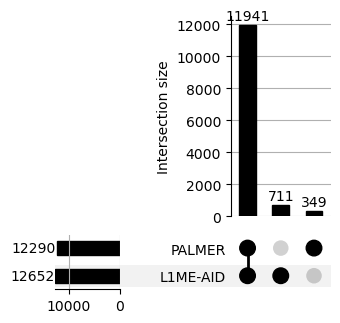

In [13]:
upsetplot.plot(toppings_count_series, sort_by="cardinality", facecolor='black', show_counts=True)
current_figure = matplotlib.pyplot.gcf()
#current_figure.savefig("/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38_Merged_finalUpset.svg")
#current_figure.savefig("/home/mark/Desktop/MEI_Group/HGSVC3/Merged_Callsets/hg38_Merged_finalUpset.png")

In [14]:
templist=[]
for lab in ['L1ME-AID_Lab','PALMER']:
    subsetDF = combinedDF[combinedDF[lab]==1].copy()
    for uniqueElement in set(subsetDF['TE_Designation']):
        if 'Alu' in uniqueElement:
            uniqueName = 'Alu'
        elif 'LINE' in uniqueElement:
            uniqueName = 'L1'
        
        elif 'SVA' in uniqueElement:
            uniqueName = 'SVA'
        
        else:
            uniqueName = uniqueElement
            
        templist.append([lab, uniqueName, len(subsetDF[subsetDF['TE_Designation']==uniqueElement])])
tempDF = pd.DataFrame(data=templist, columns=['Reference','Element','Count'])

In [15]:
tempDF

,Reference,Element,Count
0,L1ME-AID_Lab,snRNA,1
1,L1ME-AID_Lab,Alu,10260
2,L1ME-AID_Lab,L1,1631
3,L1ME-AID_Lab,SVA,760
4,PALMER,Alu,10194
5,PALMER,L1,1475
6,PALMER,SVA,615
7,PALMER,HERVK,6


In [16]:
import altair as alt
sorter=['L1ME-AID_Lab','PALMER']
sorter2 = ['Alu','L1','SVA','HERVK','snRNA']
alt.Chart(tempDF).mark_bar(size=40).encode(

    # tell Altair which field to group columns on
    x=alt.X('Element:N', title=None, sort=sorter2),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(Count):Q',
        axis=alt.Axis(
            grid=True,
            title='Total Insertions')),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Reference:N', title=None, sort=sorter),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Element:N',
                sort=sorter2,
                scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#FFC374', '#2C4E80', '#FC4100','#54A24B','#72B7B2'],
            ),
            ),
        )\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).properties(
    width=230,
    padding={"left": 10, "top": 10, "right": 10, "bottom": 10}
).configure_axisX(
    labelAngle=0  # Rotate the x-axis ticks by 45 degrees
)

alt.Chart(...)

In [17]:
chromList=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY']
samples = ['HG00096', 'HG00171', 'HG00268', 'HG00358', 'HG00512', 'HG00513',
       'HG00514', 'HG00731', 'HG00732', 'HG00733', 'HG00864', 'HG01114',
       'HG01352', 'HG01457', 'HG01505', 'HG01573', 'HG01596', 'HG01890',
       'HG02011', 'HG02018', 'HG02059', 'HG02106', 'HG02282', 'HG02492',
       'HG02554', 'HG02587', 'HG02666', 'HG02769', 'HG02818', 'HG02953',
       'HG03009', 'HG03065', 'HG03248', 'HG03371', 'HG03452', 'HG03456',
       'HG03520', 'HG03683', 'HG03732', 'HG03807', 'HG04036', 'HG04217',
       'NA12329', 'NA18534', 'NA18939', 'NA18989', 'NA19036', 'NA19129',
       'NA19238', 'NA19239', 'NA19240', 'NA19317', 'NA19331', 'NA19347',
       'NA19384', 'NA19434', 'NA19650', 'NA19705', 'NA19836', 'NA19983',
       'NA20355', 'NA20509', 'NA20847', 'NA21487', 'NA24385']

In [18]:
combinedDF['SV_Length']=[len(combinedDF.at[x,'ALT']) for x in combinedDF.index]

In [19]:
elementcounts = [[x,y] for x,y in collections.Counter(combinedDF['TE_Designation']).items()]
elementCountDF = pd.DataFrame(data=elementcounts, columns=['Element', 'Count'])
elementCountDF['Reference']='GRCh38'

In [20]:
len(combinedDF)

13001

In [21]:
elementCountDF

,Element,Count,Reference
0,Retroposon/SVA,770,GRCh38
1,SINE/Alu,10522,GRCh38
2,LINE/L1,1702,GRCh38
3,snRNA,1,GRCh38
4,HERVK,6,GRCh38


In [22]:
sum(elementCountDF['Count'])

13001

In [23]:
import altair as alt
sorter=['Konkel_Lab','PALMER}']
sorter2 = ['SINE/Alu','LINE/L1','Retroposon/SVA','HERVK','snRNA']
alt.Chart(elementCountDF).mark_bar(size=40).encode(

    # tell Altair which field to group columns on
    x=alt.X('Element:N', title=None, sort=sorter2),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(Count):Q',
        axis=alt.Axis(
            grid=True,
            title='Total Insertions')),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Reference:N', title=None, sort=sorter),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Element:N',
                sort=sorter2,
                scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#FFC374', '#2C4E80', '#FC4100','#54A24B','#72B7B2'],
            ),
            ),
        )\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).properties(
    width=250,
    height=350,
    padding={"left": 10, "top": 10, "right": 10, "bottom": 10}
).configure_axisX(
    labelAngle=0  # Rotate the x-axis ticks by 45 degrees
)

alt.Chart(...)

In [24]:
hg38tempList2= [[x,y] for x,y in collections.Counter([int(x) for x in combinedDF[combinedDF['TE_Designation']=='SINE/Alu']['SV_Length']]).items()]
hg38tempDF2 = pd.DataFrame(data=hg38tempList2, columns=['SINE/Alu Lengths','Count'])

alt.Chart(hg38tempDF2).mark_bar(color='#FFC374').encode(
    alt.X("SINE/Alu Lengths:Q", bin=alt.Bin(maxbins=25)),
    y='Count',
).properties(
    title='GRCh38 Alu Lengths'
)

alt.Chart(...)

In [25]:
hg38tempList2= [[x,y] for x,y in collections.Counter([int(x) for x in combinedDF[combinedDF['TE_Designation']=='LINE/L1']['SV_Length']]).items()]
hg38tempDF2 = pd.DataFrame(data=hg38tempList2, columns=['LINE/L1 Lengths','Count'])

alt.Chart(hg38tempDF2).mark_bar(color='#2C4E80').encode(
    alt.X("LINE/L1 Lengths:Q", bin=alt.Bin(maxbins=25)),
    y='Count',
).properties(
    title='GRCh38 L1 Lengths'
)

alt.Chart(...)

In [26]:
hg38tempList2= [[x,y] for x,y in collections.Counter([int(x) for x in combinedDF[combinedDF['TE_Designation']=='Retroposon/SVA']['SV_Length']]).items()]
hg38tempDF2 = pd.DataFrame(data=hg38tempList2, columns=['Retroposon/SVA Lengths','Count'])

alt.Chart(hg38tempDF2).mark_bar(color='#FC4100').encode(
    alt.X("Retroposon/SVA Lengths:Q", bin=alt.Bin(maxbins=25)),
    y='Count',
).properties(
    title='GRCh38 SVA Lengths'
)

alt.Chart(...)

In [27]:
samples = ['HG00096', 'HG00171', 'HG00268', 'HG00358', 'HG00512', 'HG00513',
       'HG00514', 'HG00731', 'HG00732', 'HG00733', 'HG00864', 'HG01114',
       'HG01352', 'HG01457', 'HG01505', 'HG01573', 'HG01596', 'HG01890',
       'HG02011', 'HG02018', 'HG02059', 'HG02106', 'HG02282', 'HG02492',
       'HG02554', 'HG02587', 'HG02666', 'HG02769', 'HG02818', 'HG02953',
       'HG03009', 'HG03065', 'HG03248', 'HG03371', 'HG03452', 'HG03456',
       'HG03520', 'HG03683', 'HG03732', 'HG03807', 'HG04036', 'HG04217',
       'NA12329', 'NA18534', 'NA18939', 'NA18989', 'NA19036', 'NA19129',
       'NA19238', 'NA19239', 'NA19240', 'NA19317', 'NA19331', 'NA19347',
       'NA19384', 'NA19434', 'NA19650', 'NA19705', 'NA19836', 'NA19983',
       'NA20355', 'NA20509', 'NA20847', 'NA21487', 'NA24385']

In [28]:
sampleDict={x:{'SINE/Alu':0, 'LINE/L1':0, 'Retroposon/SVA':0} for x in samples}
for row in hg38Shared.index:
    for sample in samples:
        element = str(hg38Shared.at[row,'TE_Designation'])
        genotype = str(hg38Shared.at[row,sample])
        splitGenotype = genotype.split("|")
        count = len([x for x in splitGenotype if str(x) == '1'])
        
        sampleDict[sample][element]+=count

NameError: name 'hg38Shared' is not defined

In [20]:
sampleList=[]
for key in sampleDict.keys():
    
    sampleList.append([key, sampleDict[key]['SINE/Alu'], 'Alus'])
    sampleList.append([key, sampleDict[key]['LINE/L1'], 'LINEs'])
    sampleList.append([key, sampleDict[key]['Retroposon/SVA'], 'SVAs'])
sampleDF = pd.DataFrame(data=sampleList, columns=['Sample','Count','Element'])

In [21]:
sampleOrder=['HG02587',
             'HG02666',
             'HG02769',
             'HG02818',
             'HG02953',
             'HG03065',
             'HG03248',
             'HG03371',
             'HG03452',
             'HG03456',
             'HG03520',
             'NA19036',
             'NA19129',
             'NA19238',
             'NA19239',
             'NA19240',
             'NA19317',
             'NA19331',
             'NA19347',
             'NA19384',
             'NA19434',
             'NA21487',
             'HG01890',
             'HG02011',
             'HG02282',
             'HG02554',
             'NA19705',
             'NA19836',
             'NA19983',
             'NA20355',
             'HG00731',
             'HG00732',
             'HG00733',
             'HG01114',
             'HG01352',
             'HG01457',
             'HG01573',
             'HG02106',
             'NA19650',
             'HG00512',
             'HG00513',
             'HG00514',
             'HG00864',
             'HG01596',
             'HG02018',
             'HG02059',
             'NA18534',
             'NA18939',
             'NA18989',
             'HG00096',
             'HG00171',
             'HG00268',
             'HG00358',
             'HG01505',
             'NA12329',
             'NA20509',
             'NA24385',
             'HG02492',
             'HG03009',
             'HG03683',
             'HG03732',
             'HG03807',
             'HG04036',
             'HG04217',
             'NA20847' 
            ]

In [22]:
import altair as alt
sorter=chromList
sorter2=['ALUs' , 'LINEs', 'SVAs']
alt.Chart(sampleDF).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('Element:N', title=None, sort=sampleOrder),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(Count):Q',
        axis=alt.Axis(
            grid=True,
            title='Total Insertions'), sort=sampleOrder),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Sample:N', title=None, sort=sampleOrder),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Element:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#FFC374', '#2C4E80', '#FC4100'],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).properties(
    width=100,
    padding={"left": 20, "top": 20, "right": 20, "bottom": 20}
).configure_axisX(
    labelAngle=0  # Rotate the x-axis ticks by 45 degrees
)

alt.Chart(...)

In [23]:
chromList=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY']

In [24]:
tempChromList = []
for chromosome in chromList:
    
    insRows = [x for x in hg38Shared.index if '-INS-' in str(x)]

    insDF = hg38Shared.loc[insRows].copy()

    insDFchromDF = insDF[insDF['CHROM']==chromosome].copy()

    
    instempDict = collections.Counter(insDFchromDF['TE_Designation'])
    
    tempChromList.append([chromosome, instempDict['SINE/Alu'], 'Alus'])
    tempChromList.append([chromosome, instempDict['LINE/L1'], 'LINEs'])
    tempChromList.append([chromosome, instempDict['Retroposon/SVA'], 'SVAs'])

chromDF = pd.DataFrame(data=tempChromList, columns=['Chromosome', 'Count', 'Element'])

In [25]:
import altair as alt
sorter=chromList
sorter2=['ALUs' , 'LINEs', 'SVAs']
alt.Chart(chromDF).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('Element:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(Count):Q',
        axis=alt.Axis(
            grid=True,
            title='Total Insertions')),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Chromosome:N', title=None, sort=chromList),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Element:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#FFC374', '#2C4E80', '#FC4100'],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).properties(
    width=100,
    padding={"left": 20, "top": 20, "right": 20, "bottom": 20}
).configure_axisX(
    labelAngle=0  # Rotate the x-axis ticks by 45 degrees
)

alt.Chart(...)

In [26]:
chromDF

,Chromosome,Count,Element
0,chr1,822,Alus
1,chr1,130,LINEs
2,chr1,67,SVAs
3,chr2,854,Alus
4,chr2,123,LINEs
...,...,...,...
67,chrX,81,LINEs
68,chrX,11,SVAs
69,chrY,10,Alus
70,chrY,7,LINEs


In [27]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset
chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("hg38")

In [28]:
hg38LengthDF = pd.read_csv('/home/mark/.cache/pycirclize/eukaryote/hg38/hg38_chr.bed', sep='\t', comment='#', header=None)
hg38LengthDict = {str(hg38LengthDF.at[row,0]):int(hg38LengthDF.at[row,2])/1000000 for row in hg38LengthDF.index}

In [29]:
chromDF2 = chromDF.copy()
for row in chromDF2.index:
    chromDF2.at[row,'Count']=int(chromDF.at[row,'Count'])/hg38LengthDict[chromDF.at[row,'Chromosome']]

In [30]:
chromDF2

,Chromosome,Count,Element
0,chr1,3.301783,Alus
1,chr1,0.522180,LINEs
2,chr1,0.269123,SVAs
3,chr2,3.526106,Alus
4,chr2,0.507858,LINEs
...,...,...,...
67,chrX,0.519095,LINEs
68,chrX,0.070494,SVAs
69,chrY,0.174741,Alus
70,chrY,0.122319,LINEs


In [31]:
sorter=chromList
sorter2=['ALUs' , 'LINEs', 'SVAs']
alt.Chart(chromDF2).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('Element:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(Count):Q',
        axis=alt.Axis(
            grid=True,
            title='Insertions per Mbp')),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Chromosome:N', title=None, sort=chromList),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Element:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#FFC374', '#2C4E80', '#FC4100'],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).properties(
    width=100,
    padding={"left": 20, "top": 20, "right": 20, "bottom": 20}
).configure_axisX(
    labelAngle=0  # Rotate the x-axis ticks by 45 degrees
)

alt.Chart(...)